# EX-10-June-2024-Analysis

## Set up

In [1]:
# Standard python imports
import umap                     # dimension reduction
import pandas as pd             # working with tables & spreadsheets
import numpy as np              # working with matrices & numbers
import seaborn as sns           # visualization
import matplotlib.pyplot as plt # visualization

In [2]:
# Packages for working with text and embeddings
from langchain.embeddings import HuggingFaceEmbeddings # Embedding text to vectors

In [34]:
# Load results from experiment
dfQ   = pd.read_csv('EX-10-June-2024-Qs.csv')
dfLLM = pd.read_csv('EX-10-JUNE-2024-LLM-llama3-70b.csv')
dfRAG = pd.read_csv('EX-10-JUNE-2024-RAG-llama3-70b.csv')

# What do the Questions Look Like

In [35]:
summary = dfQ.sum()
summary_df = summary.reset_index()
summary_df.columns = ['Column', 'True Count']
summary_df = summary_df.drop(0)  # Drop prompt question
print(summary_df)
bioColumns  = ['Reprogramming', 'Cell Bio', 'Epigenetics', 'Experiments', 'Cancer']
mathColumns = ['Dynamical Systems', 'Networks', 'Higher Order Structure', 'Linear Algebra']
dfQ['bio']  = dfQ[bioColumns].any(axis=1)
dfQ['math'] = dfQ[mathColumns].any(axis=1)


                    Column True Count
1        Factual/Objective         74
2             Interpretive         71
3               Procedural         54
4            Reprogramming         57
5                 Cell Bio         61
6              Epigenetics         64
7              Experiments         17
8                   Cancer         11
9        Dynamical Systems         17
10                Networks         10
11  Higher Order Structure         15
12          Linear Algebra         12
13                   Other          0
14             Unnamed: 14        0.0
15            discard vvvv        120


## Distribution of Question Types

In [38]:
qtypes = ['Factual/Objective', 'Interpretive', 'Procedural']

In [57]:
total_bio = dfQ['bio'].sum()
total_math = dfQ['math'].sum()

summary = {
    'bio': {qtype: dfQ[dfQ['bio']][qtype].sum() / total_bio for qtype in qtypes},
    'math': {qtype: dfQ[dfQ['math']][qtype].sum() / total_math for qtype in qtypes}
}


<Figure size 1920x1440 with 0 Axes>

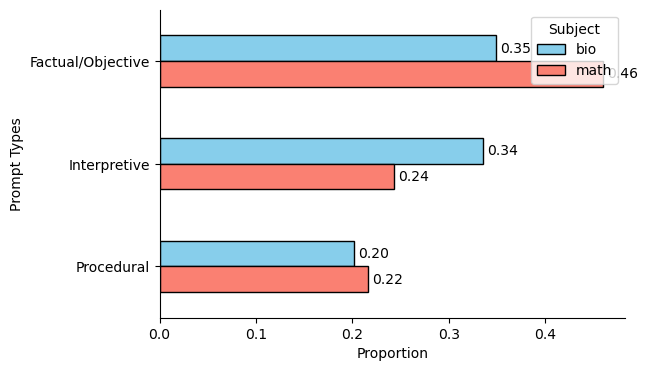

In [64]:
plt.figure(dpi=300)
ax = summary_df.plot(kind='barh',
                figsize=(6, 4),
                color=['skyblue', 'salmon'],
                edgecolor='k'
                )
plt.xlabel('Proportion')
plt.ylabel('Prompt Types')
plt.xticks(rotation=0)
plt.legend(title='Subject', loc='upper right')
sns.despine()

# Customize labels for better readability
plt.gca().invert_yaxis()  # Highest values at the top
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.show()


<Figure size 1920x1440 with 0 Axes>

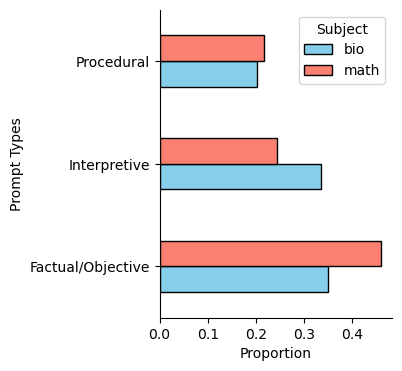

In [63]:
summary_df = pd.DataFrame(summary)

plt.figure(dpi=300)
summary_df.plot(kind='barh',
                figsize=(3, 4),
                color=['skyblue', 'salmon'],
                edgecolor='k',
                )
plt.xlabel('Proportion')
plt.ylabel('Prompt Types')
# plt.title('Count of Each Question Type by Bio and Math Categories')
plt.xticks(rotation=0)
plt.legend(title='Subject')
sns.despine()
plt.show()


In [37]:
print(dfQ[dfQ['Cancer'] == True]['Question'].values)

['How can the mis-expression of master regulator transcription factors reverse or redirect development, and what implications does this have for cancer development?'
 'What challenges have researchers faced in linking genomic alterations to the transcriptional identity of cancer cells, and how does this study aim to address them?'
 'How are the 112 transcriptionally distinct tumor subtypes defined and characterized in this study?'
 'In what ways do MRBs regulate key cancer hallmarks and influence patient outcomes across multiple cohorts?'
 'What insights were gained regarding the impact of somatic alterations on master regulator activity in individual cancer samples?'
 'What mechanisms were proposed for how genetic alterations lead to changes in transcriptional identity and non-oncogene dependencies?'
 'How can the co-analysis of mutational and gene expression profiles contribute to identifying elusive cancer subtypes and generating testable hypotheses for the mechanisms mediating gene

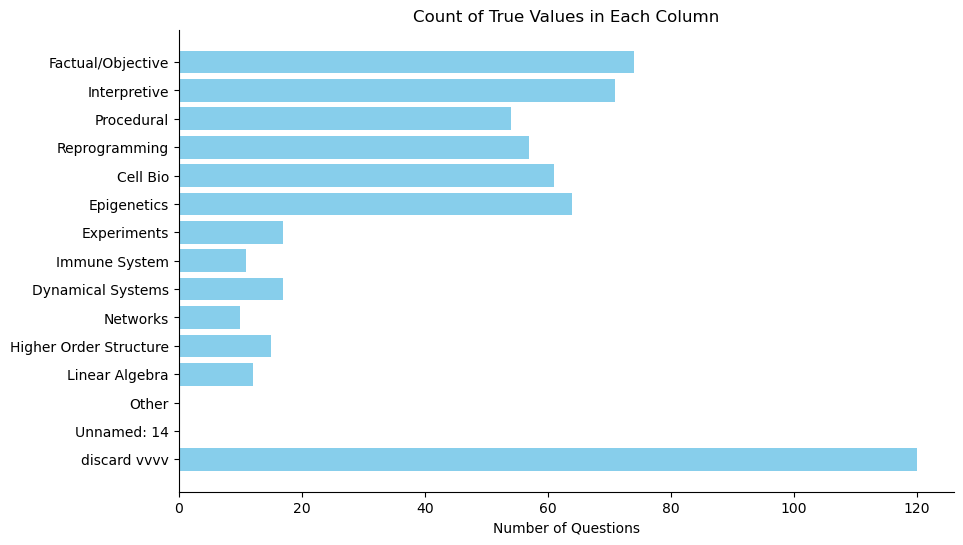

In [23]:
plt.figure(figsize=(10, 6))
plt.barh(summary_df['Column'], summary_df['True Count'], color='skyblue')
plt.xlabel('Number of Questions')
#plt.ylabel('Columns')
plt.title('Count of True Values in Each Column')
plt.gca().invert_yaxis()
sns.despine()
plt.show()


# Represent Prompts as Vectors

In [5]:
# Load the embedder model
embedder = HuggingFaceEmbeddings(model_name='BAAI/bge-base-en-v1.5')

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
uniquePrompts = list(dfRAG['prompt'].unique()) # Get the unique prompts

In [9]:
# convert each prompt to an embedding
embeddings = []
for prompt in uniquePrompts:
    embeddings.append(embedder.embed_query(prompt))
embeddings = np.array(embeddings)

In [10]:
# make umap embeddings
reducer = umap.UMAP(n_components=2, random_state=2)
embedding = reducer.fit_transform(embeddings)

udf = pd.DataFrame()           # save umap results to a dataframe
udf['UMAP 1'] = embedding[:,0]
udf['UMAP 2'] = embedding[:,1]
udf['Prompt'] = uniquePrompts

/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [11]:
# makde some new columns in umap dataframe for number of words and length of each prompt
udf['len'] = udf['Prompt'].str.len()
udf['nwords'] = udf['Prompt'].str.split(' ').apply(len)

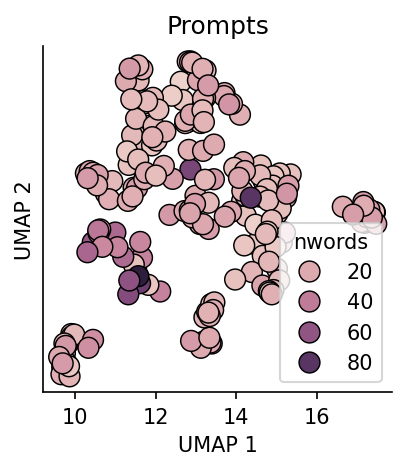

In [13]:
# visualize the prompt embeddings
plt.figure(figsize=(3, 3), dpi=150)
sns.scatterplot(data=udf,
                x='UMAP 1',
                y='UMAP 2',
                hue='nwords',
                #palette='Paired',  # Alternative palettes: 'Set2', 'tab10', 'Accent', 'Paired'
                edgecolor='k',  # Set the edge color to black
                s=100,
                #legend = False,
                linewidth=0.7)  # Adjust the width of the edge

plt.title('Prompts')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
#plt.xticks([])
plt.yticks([])
sns.despine()
plt.show()


In [11]:
# What is this outlieing cluster?
udf[udf['UMAP 1'] > 5]

# Ah it is the set of prompts related to math

,UMAP 1,UMAP 2,Prompt,len,nwords
0,11.518181,9.686843,Gene regulation is often described from the pe...,382,58
1,12.115564,9.256292,Compare and contrast the utility of dynamical ...,257,37
2,12.863033,11.607602,Synthetic lethality occurs when the knockout o...,402,69
3,11.443418,12.071386,The addition of transcription factors have bee...,245,40
4,12.344992,10.731910,RNAi is used to silence different genes. How l...,153,27
...,...,...,...,...,...
202,10.583184,10.435160,Chromatin conformation capture methods are one...,273,42
203,10.685096,10.117140,I recently completed my Hi-C experiment and ha...,186,34
204,10.315938,10.012820,"Often, Hi-C data from chromatin conformation c...",326,50
205,10.454708,8.324633,"In nonlinear control theory, there are differe...",191,31


# Responses from LLM Only

In [68]:
# convert each prompt to an embedding
embeddings = []
for prompt in dfLLM['response-0']:
    embeddings.append(embedder.embed_query(prompt))
for prompt in dfLLM['response-1']:
    embeddings.append(embedder.embed_query(prompt))
embeddings = np.array(embeddings)
print(embeddings.shape)

(414, 768)


In [69]:
# make umap embeddings
reducer = umap.UMAP(n_components=2, random_state=2)
embedding = reducer.fit_transform(embeddings)

udf = pd.DataFrame()           # save umap results to a dataframe
udf['UMAP 1'] = embedding[:,0]
udf['UMAP 2'] = embedding[:,1]
udf['Prompt'] = list(dfLLM['response-0']) + list(dfLLM['response-1'])

/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


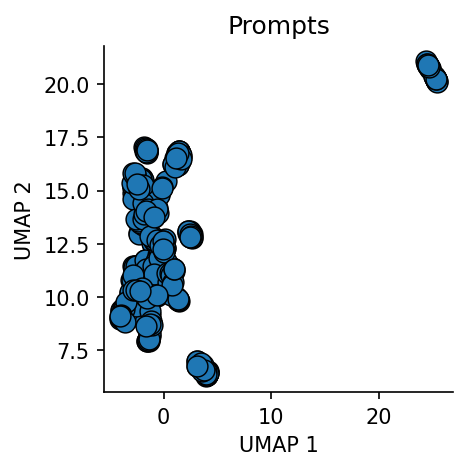

In [14]:
# visualize the prompt embeddings
plt.figure(figsize=(3, 3), dpi=150)
sns.scatterplot(data=udf,
                x='UMAP 1',
                y='UMAP 2',
                #hue='nwords',
                #palette='Paired',  # Alternative palettes: 'Set2', 'tab10', 'Accent', 'Paired'
                edgecolor='k',  # Set the edge color to black
                s=100,
                #legend = False,
                linewidth=0.7)  # Adjust the width of the edge

plt.title('Prompts')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
#plt.xticks([])
#plt.yticks([])
sns.despine()
plt.show()

In [64]:
udf[(udf['UMAP 2'] < -4) & (udf['UMAP 1'] < 3)]

,UMAP 1,UMAP 2,Prompt
6,1.432011,-5.311302,I don't know the exact relationship between th...
7,1.146505,-5.324695,"According to the context, Harold Weintraub's d..."
11,0.641910,-5.260585,I don't know the specific transcription factor...
52,1.078184,-5.399102,MyoD is a transcription factor that binds to s...
53,1.093116,-5.190405,I don't know the specific targets and first-or...
73,1.197696,-5.390396,MyoD is a master regulatory gene that plays a ...
74,1.403552,-5.129912,I don't know the answer to this question. The ...
75,1.435755,-5.008493,"According to the available literature, several..."
76,1.063877,-5.210805,I don't know the specific answer to this quest...
77,1.227828,-5.504432,I don't know the specific effects of MyoD expr...


In [61]:
udf[udf['UMAP 2'] > 7]

,UMAP 1,UMAP 2,Prompt
174,0.777028,8.943130,"Unfortunately, I don't know of a specific meth..."
175,0.765376,8.834894,The Kronecker product and the tensor product a...
176,0.417849,8.741407,A graph product is a way of combining two grap...
177,0.836562,8.874559,"The Kronecker decomposition, also known as the..."
178,0.864916,8.746962,The Kronecker product! It's a mathematical ope...
179,0.765629,8.839939,What a great question!\n\nThe Kronecker produc...
180,-0.020950,8.682843,Simplicial complexes and hypergraphs are both ...
181,-0.085536,8.640036,I don't know the exact relationship between dy...
182,0.631678,9.037052,Tensor eigenvalues and matrix eigenvalues are ...
183,0.580219,9.018688,"Yes, there is a relationship between eigenvalu..."


In [59]:
udf[udf['UMAP 1'] > 10]

,UMAP 1,UMAP 2,Prompt
23,17.579493,-4.770941,I don't know.
62,17.122953,-3.906010,I don't have enough information to provide a s...
67,17.574654,-4.850346,I don't know.
105,17.530663,-4.839203,I don't know.
111,17.590445,-4.831063,I don't know.
112,17.137541,-3.913377,I don't have enough information to provide a s...
115,17.322298,-4.035203,I don't know the answer to this question as it...
127,17.531555,-4.798528,I don't know.
135,17.392286,-4.555184,"I don't know. The provided context is empty, a..."
137,17.717152,-4.706528,I don't know.


# Responses from RAG

In [19]:
# convert each prompt to an embedding
embeddings = []
for prompt in dfRAG['response']:
    embeddings.append(embedder.embed_query(prompt))
embeddings = np.array(embeddings)
print(embeddings.shape)

(2070, 768)


In [20]:
# make umap embeddings
reducer = umap.UMAP(n_components=2, random_state=2)
embedding = reducer.fit_transform(embeddings)

udf = pd.DataFrame()           # save umap results to a dataframe
udf['UMAP 1'] = embedding[:,0]
udf['UMAP 2'] = embedding[:,1]
# udf['Prompt'] = list(dfLLM['response-0']) + list(dfLLM['response-1'])

/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


ValueError: Length of values (414) does not match length of index (2070)

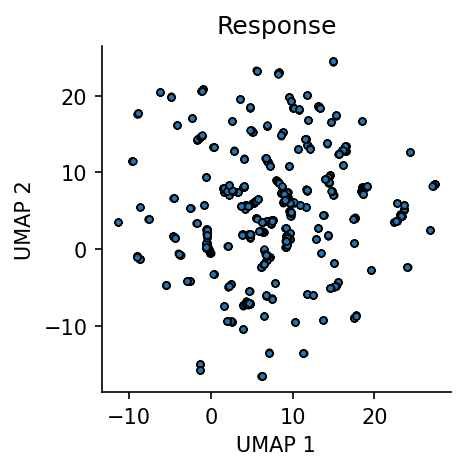

In [25]:
# visualize the prompt embeddings
plt.figure(figsize=(3, 3), dpi=150)
sns.scatterplot(data=udf,
                x='UMAP 1',
                y='UMAP 2',
                #hue='nwords',
                #palette='Paired',  # Alternative palettes: 'Set2', 'tab10', 'Accent', 'Paired'
                edgecolor='k',  # Set the edge color to black
                s=10,
                #legend = False,
                linewidth=0.7)  # Adjust the width of the edge

plt.title('Response')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
#plt.xticks([])
#plt.yticks([])
sns.despine()
plt.show()

In [21]:
udf

,UMAP 1,UMAP 2
0,11.802341,13.528522
1,11.777858,13.544023
2,11.749871,13.530104
3,11.803268,13.535081
4,11.837284,13.492243
...,...,...
2065,13.751789,-9.221055
2066,13.755180,-9.222028
2067,13.766499,-9.222580
2068,13.754936,-9.221504
